#  Cat Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [9]:

# First we will extract the data, and save it to a csv.

# Machine Learning Model
import catboost as cb

# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data Display Tools
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import f_regression

import feature_generation as feat_gen
import data_processing as dat_proc

%matplotlib inline



### Extract data

In [10]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

print(train_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34085 entries, 0 to 34084
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            34085 non-null  datetime64[us]
 1   pv_measurement  34085 non-null  float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 532.7 KB
None


### Example for adding all the data -- Am

In [37]:
def add_all(train: pd.DataFrame, observe: pd.DataFrame):
    observe = observe.rename(columns={'date_forecast': 'time'})
    merged = pd.merge(train, observe, on = "time", how = "left")
    # Kan legge til ensure the timestamp column is in datetime format
    remove_nan = merged[~np.isnan(merged["pv_measurement"])]
    y = remove_nan[["time", "pv_measurement"]].copy()
    X = remove_nan.drop(columns = ["time","pv_measurement"], axis = 1) # drop_time

    return X, y

# Read Data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

# Merge data
X_all_a, y_all_a = add_all(train_a, X_train_observed_a)
X_all_b, y_all_b = add_all(train_b, X_train_observed_b)
X_all_c, y_all_c = add_all(train_c, X_train_observed_c)

X_all = pd.concat([X_all_a,X_all_b,X_all_c], axis = 0)
y_all = pd.concat([y_all_a,y_all_b,y_all_c], axis = 0)

### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

In [43]:
# X_train_estimated_a = X_train_estimated_a.drop("date_calc", axis = 1)

X = X_all #pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)

# Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
X = X.interpolate(method='linear')
X = X.bfill()

# Extract necesarry values for feature generation.
timestamps = "time"
measurements = list(X.columns.values)
measurements.remove(timestamps)

# Probable features that may be used
der_df = feat_gen.difference_df(X, timestamps, measurements)
dder_df = feat_gen.double_derivative_from_df(X, timestamps, measurements)
int_df = feat_gen.daily_accumulated_val_df(X, timestamps, measurements)
dint_df = feat_gen.daily_accumulated_val_squared_df(X, timestamps, measurements)
time_df = feat_gen.time_data_from_df(X, timestamps)

# Reset the Index of the DataFrames
X = X.reset_index(drop=True)
der_df = der_df.reset_index(drop=True)
dder_df = dder_df.reset_index(drop=True)
int_df = int_df.reset_index(drop=True)
dint_df = dint_df.reset_index(drop=True)
time_df = time_df.reset_index(drop=True)

# Concatenate the DataFrames
X = pd.concat([X, der_df, dder_df, int_df, dint_df, time_df], axis="columns")

# Defind y
y = y_all # train_a.dropna()

# Additional features
der_y = feat_gen.difference_df(y, "time", ["pv_measurement"])
der_y_shifted = feat_gen.shifted_values_24_h(der_y, "derivative_pv_measurement")
y_shifted =  feat_gen.shifted_values_24_h(y, "pv_measurement")

# # Adding together the added features to one dataframe.
y_BIG = pd.concat([y, der_y, der_y_shifted, y_shifted])


# # Making sure that the two dataframes match in length.
# y_BIG, X = dat_proc.data_length_matching(y_BIG, X)

# # Get our desired output
# y = y_BIG["derivative_pv_measurement"]
# y.info()
# y = y.reset_index(drop = True)

# # Removing datetime object column
# y_features = y_BIG.drop('pv_measurement', axis=1)
# y_features = y_features.drop('derivative_pv_measurement', axis=1)
# # y_features = y_features.drop('time', axis=1)
# y_features = y_features.reset_index(drop = True)

# # Removing datetime object column
# X = X.reset_index(drop = True)
# X = X.drop(timestamps, axis=1)

# X = pd.concat([X, y_features], axis = "columns")
X = pd.concat([X, y_BIG], axis = "columns")

# #X = SelectKBest(f_regression, k=12).fit_transform(X, y)

KeyError: 'derivative_pv_measurement'

In [4]:
print(y_BIG.columns.values)

['time' 'pv_measurement' 'derivative_pv_measurement'
 'derivative_pv_measurementn-1' 'derivative_pv_measurementn-2'
 'derivative_pv_measurementn-3' 'derivative_pv_measurementn-4'
 'derivative_pv_measurementn-5' 'derivative_pv_measurementn-6'
 'derivative_pv_measurementn-7' 'derivative_pv_measurementn-8'
 'derivative_pv_measurementn-9' 'derivative_pv_measurementn-10'
 'derivative_pv_measurementn-11' 'derivative_pv_measurementn-12'
 'derivative_pv_measurementn-13' 'derivative_pv_measurementn-14'
 'derivative_pv_measurementn-15' 'derivative_pv_measurementn-16'
 'derivative_pv_measurementn-17' 'derivative_pv_measurementn-18'
 'derivative_pv_measurementn-19' 'derivative_pv_measurementn-20'
 'derivative_pv_measurementn-21' 'derivative_pv_measurementn-22'
 'derivative_pv_measurementn-23' 'derivative_pv_measurementn-24'
 'pv_measurementn-1' 'pv_measurementn-2' 'pv_measurementn-3'
 'pv_measurementn-4' 'pv_measurementn-5' 'pv_measurementn-6'
 'pv_measurementn-7' 'pv_measurementn-8' 'pv_measureme

In [5]:
# DO we get a day or the 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\Users\isakasa\AppData\Local\anaconda3\envs\basic_machine_learning\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\isakasa\AppData\Local\anaconda3\envs\basic_machine_learning\Lib\site-packages\sklearn\preprocessing\_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


## AI Training: CatBoost


In [7]:

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="RMSE", logging_level='Silent')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)


pred = model.predict(X_test)
mae = (mean_absolute_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("Mean Abs: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))



CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/metrics/metric.cpp:6547: metric/loss-function RMSE do not allows nan value on target

In [ ]:
N = 100

feature_importance = model.get_feature_importance()

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(model.feature_names_, feature_importance))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or use the top features
top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
print(top_features)
labels = list(X.columns.values)

for feat in top_features:
    print(labels[int(feat[0])])


[('10', 20.675976748743423), ('4', 5.717517993130504), ('11', 4.450502567659519), ('8', 3.4095005018847004), ('9', 3.3269370092606416), ('36', 2.9411478427345803), ('56', 2.348280724512728), ('42', 2.173713934079064), ('227', 1.8999966663240988), ('55', 1.6735082211569492), ('178', 1.5729719537899434), ('173', 1.4996321670916388), ('100', 1.4971057435262434), ('80', 1.4647239818262547), ('204', 1.2149372391273856), ('3', 1.1593922347524483), ('101', 1.1499454239386908), ('48', 1.1177603603338644), ('2', 1.096297169023833), ('7', 1.0855219816659136), ('225', 1.0854749634065948), ('0', 1.0477856072687945), ('214', 0.9517544833579291), ('172', 0.943220960884357), ('140', 0.8336230531782166), ('5', 0.7888815978357957), ('39', 0.7811396042950445), ('25', 0.7739278881245186), ('200', 0.7631341092171996), ('222', 0.7599256108439204), ('38', 0.7468332987715831), ('29', 0.6799132812409796), ('53', 0.663968129425512), ('185', 0.6614300683231882), ('24', 0.6441616472750528), ('223', 0.62265018276

### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

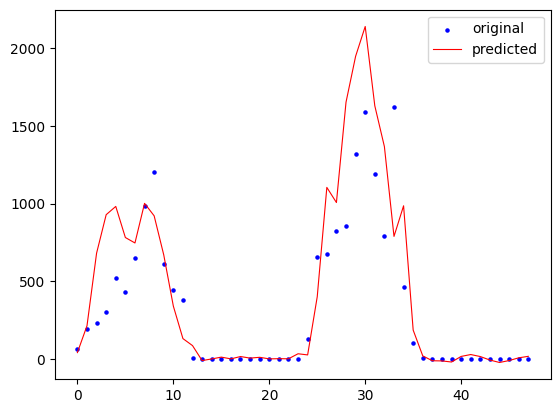

In [ ]:


x_ax = range(48)
plt.scatter(x_ax, y_test[0:48], s=5, color="blue", label="original")
plt.plot(x_ax, pred[0:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
